Import relevant packages

In [19]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

import scienceplots
from scipy.optimize import fsolve
import helium4plusplus as he4
plt.style.use('science')
gr = 4/3
h = 3

Set parameters and load LO RG flow:

In [14]:
# angular momentum
ELL = 0
# load lo coupling constants
Rs, gs = np.loadtxt('datfiles/he4plusplus_LO_nonlocal2_2_6_6_rg_flow.txt', unpack=True)
# number of short distance cutoffs
nR = Rs.size

N1 = 2
N2 = 6
NCT = 6

In [3]:
# momentum grid
momenta = np.linspace(0.01/he4.BETA6, 0.3/he4.BETA6, 30)

# scale to render g dimensionless
X = he4.FACTOR * he4.BETA6 # K•Å^3

# kcotd delta returned from a and r
KCD = -1/he4.A0 + he4.R0/2*momenta**2

# First, we will tune k(cot(delta)). Then we'll go back and refine a_0 and r_0.
def kcd_diff(gpair, sys):
    kcd = sys.kcotd_gen_pert1_fast(momenta, *gpair)
    return np.sum(((KCD - kcd)/KCD)**2)

In [21]:
def a0_diff(gi, gj, sys):
    a0, _ = sys.a0_and_r0_pert1_fast(gi,gj,momenta)
    return (he4.A0 - a0)/he4.A0

Set up the system for the interaction loaded and a specific R

In [4]:
R=Rs[0]
print(R)
s = he4.NonlocalHelium4System2(R, ELL, N1, N2, NCT)

2.770625


In [5]:
glos[0]

2.3114653427023897

At LO scattering length agrees but effective range (slope of $k\cot\delta$ as function of $k^2$) does not

Text(0, 0.5, '$k \\cot\\delta$')

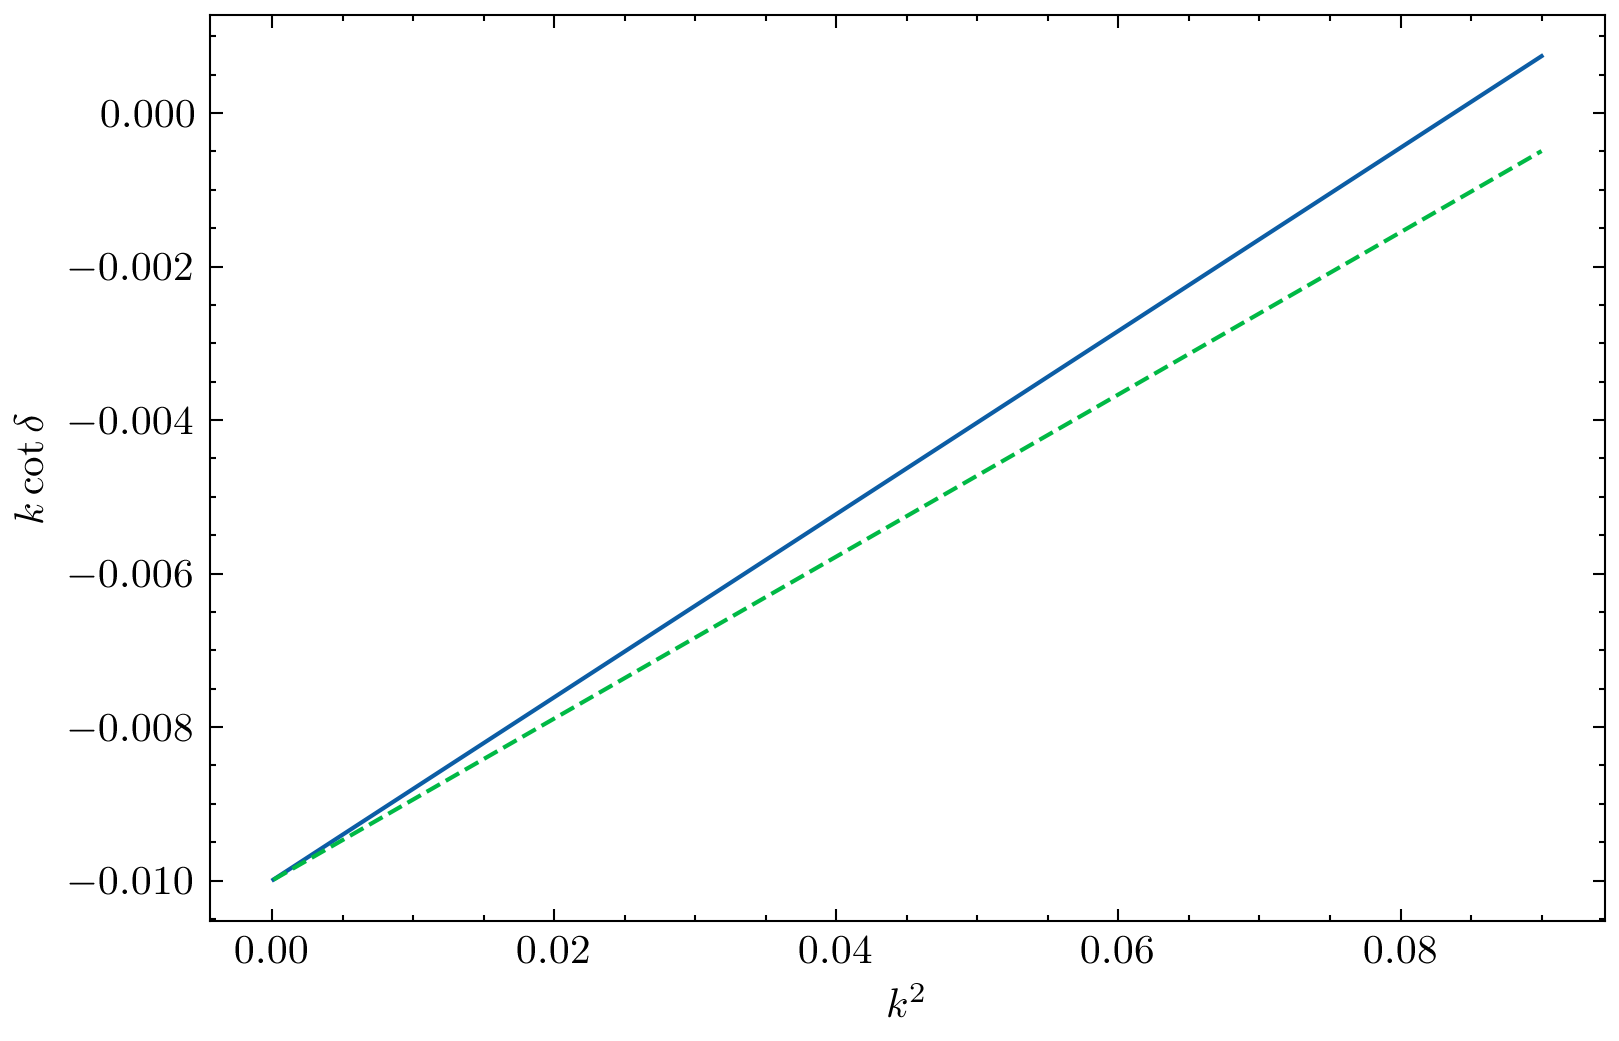

In [10]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

ax.plot((momenta*he4.BETA6)**2, KCD)
ax.plot((momenta*he4.BETA6)**2, s.kcotd_gen_pert1_fast(momenta, glos[0], 0), linestyle='--');
ax.set_xlabel('$k^2$')
ax.set_ylabel('$k \cot\delta$')

Now adjust the search algorithm from the notebook in which we iterated the NLO piece to the perturbative approach:

In [300]:
NR = 13
print(Rs[NR])
print(gs[NR])

1.5427343749999998
-45.81456756385357


In [301]:
R=Rs[NR]
print(R)
s = he4.NonlocalHelium4System2(R, ELL, N1, N2, NCT)

1.5427343749999998


In [302]:
s.a0_and_r0_pert1_fast(gs[NR], 0., momenta)

(99.99999998015622, 7.344365158995974)

In [ ]:
xhi =0.001
xlo=1200000.
steps = 6000
stepsize = abs(xhi-xlo)/steps
print('stepsize = ',stepsize)

#glo_nlo_refit = np.array([[lo_semilocal_gs[NR], 0.]])
#astart, rstart = s.a0_and_r0(lo_semilocal_gs[NR], 0., momenta, use_c=True)


lucas_glo = gs[NR]
glo_nlo_refit = np.array([[lucas_glo, 0.]])
astart, rstart = s.a0_and_r0(lucas_glo, 0., momenta, use_c=True)

if(rstart < he4.R0):
    stepsize = -stepsize
    sign = -1.
    print('sign = ',sign)
else:
    stepsize = 1.*stepsize
    sign = 1.
    print('sign =',sign)

stepsize = stepsize
test_results = np.array([[astart,rstart]])
#glo_nlo_refit = np.array([[, 0.]])
#guess = lo_semilocal_gs[NR]
guess = lucas_glo

gnlo = xhi
for i in range(steps):
    result = optimize.fsolve(a0_diff, guess, args=(gnlo, s),xtol=1e-14)
    temp = np.array([0., 0.])
    temp[0],temp[1]= s.a0_and_r0_pert1_fast(result[0], gnlo, momenta)

    if(abs(temp[0]-100)<0.5 and (sign*temp[1] > sign*he4.R0) and (abs(temp[1] - he4.R0) > 0.004)):
        test_results = np.append(test_results,[temp],axis = 0)
#        glo_refit.append(result[0])
        glo_nlo_refit = np.append(glo_nlo_refit,np.array([[result[0],gnlo]]),axis =0)
        gnlo = gnlo + stepsize
        guess = result[0]
        print(f"below but not close enough, r0={temp[1]} with gnlo = {gnlo}")
    elif(abs(temp[0]-100)<0.5 and (sign*temp[1] > sign*he4.R0) and (abs(temp[1] - he4.R0) < 0.004)):
        test_results = np.append(test_results,[temp],axis = 0)
#        glo_refit.append(result[0])
        glo_nlo_refit = np.append(glo_nlo_refit,np.array([[result[0],gnlo]]),axis =0)
        print('below and sufficiently close, r0=',temp[1])
        break
    elif(abs(temp[0]-100)<0.5 and (sign*temp[1] < sign*he4.R0) and (abs(temp[1] - he4.R0) < 0.004)):
        test_results = np.append(test_results,[temp],axis = 0)
#        glo_refit.append(result[0])
        glo_nlo_refit = np.append(glo_nlo_refit,np.array([[result[0],gnlo]]),axis =0)
        print('above and sufficiently close, r0=',temp[1])
        break
    elif(abs(temp[0]-100)<0.5 and (sign*temp[1] < sign*he4.R0) and (abs(temp[1] - he4.R0) > 0.004)):
        gnlo = gnlo - 0.9*stepsize
        stepsize = 0.9*stepsize
        print('above but not close enough')
    elif(abs(temp[0]-100)>0.5):
        print('did not find correct scattering length need to return to previous point')
        gnlo = gnlo - stepsize
        stepsize = 0.9*stepsize
    else:
        print('no valid if statement, breaking')
        break

stepsize =  199.99999983333333
sign = 1.0
below but not close enough, r0=7.344369372848529 with gnlo = 200.00099983333334
above but not close enough
below but not close enough, r0=15.03360775335347 with gnlo = 200.00099983333334
above but not close enough
below but not close enough, r0=11.533417373167227 with gnlo = 200.00099983333334
above but not close enough
below but not close enough, r0=9.885454025413653 with gnlo = 200.00099983333334
above but not close enough
below but not close enough, r0=8.899324517451582 with gnlo = 200.00099983333334
above but not close enough
below but not close enough, r0=8.232742756580643 with gnlo = 200.00099983333334
above but not close enough
below but not close enough, r0=7.749415015508304 with gnlo = 200.00099983333334
above but not close enough
below but not close enough, r0=7.382595088566467 with gnlo = 200.00099983333334
above but not close enough
above but not close enough
below but not close enough, r0=11.74528174184767 with gnlo = 113.907557905

In [297]:
result_data = np.transpose(np.vstack((np.transpose(glo_nlo_refit),np.transpose(test_results))))

In [298]:
np.savetxt(f'gLO_gNLO_perturbative_R_{R}.dat', result_data)

In [299]:
print(R)
print(result_data[-1][0])
print(result_data[-1][1])

1.5971838235294118
-94.19534391313341
149.16368330911777


In [208]:
s.a0_and_r0_pert1_fast(result_data[-1][0], result_data[-1][1], momenta)

(99.99999999908668, 7.333165528923678)

In [252]:
s.a0_and_r0_pert1_fast(2.56425007e+02, 13.046,momenta)

(99.99998118497197, 7.33208584644456)

In [253]:
print(R)

1.9394375


In [213]:
glo_nlo_refit

array([[2.32371752e+02, 0.00000000e+00],
       [2.32373576e+02, 1.00000000e-03],
       [2.32510695e+02, 7.59975000e-02],
       [2.32648441e+02, 1.50995000e-01],
       [2.32786818e+02, 2.25992500e-01],
       [2.32925832e+02, 3.00990000e-01],
       [2.33065486e+02, 3.75987500e-01],
       [2.33205784e+02, 4.50985000e-01],
       [2.33346732e+02, 5.25982500e-01],
       [2.33488333e+02, 6.00980000e-01],
       [2.33630592e+02, 6.75977500e-01],
       [2.33773514e+02, 7.50975000e-01],
       [2.33917103e+02, 8.25972500e-01],
       [2.34061364e+02, 9.00970000e-01],
       [2.34206301e+02, 9.75967500e-01],
       [2.34351919e+02, 1.05096500e+00],
       [2.34498223e+02, 1.12596250e+00],
       [2.34645217e+02, 1.20096000e+00],
       [2.34792905e+02, 1.27595750e+00],
       [2.34941293e+02, 1.35095500e+00],
       [2.35090384e+02, 1.42595250e+00],
       [2.35240185e+02, 1.50095000e+00],
       [2.35390699e+02, 1.57594750e+00],
       [2.35541931e+02, 1.65094500e+00],
       [2.356938

In [191]:
1.1724e+01

11.724

In [254]:
2.56425007e+02

256.425007